## PEMANGGILAN LIBRARY

In [1]:
import os
import re
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import rasterio as rio
import geopandas as gpd
import rioxarray as rxr

from glob import glob
from shapely import speedups
from rasterio import plot, mask
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches, colors

from rasterio.crs import CRS
from shapely.geometry import mapping
from matplotlib.colors import ListedColormap, BoundaryNorm

speedups.disable()

## IMPORT DATA BARU

In [2]:
landsat_dir = "dataset/landsat/LC08_L2SP_122065_20190725_20200827_02_T1/"
band_names = (2, 3, 4, 5, 10)
coor_ref = "EPSG:4326"

year, month, date = landsat_dir[33:37], landsat_dir[37:39], landsat_dir[39:41]
time = f"{year}-{month}-{date}"

preprocessed_band = dict()

for i in band_names:
    with rxr.open_rasterio(f"output/landsat/{time}/B{i}.TIF", masked=True) as raster:
        preprocessed_band[i] = raster.squeeze().rio.reproject(CRS.from_string(coor_ref))

temperature = preprocessed_band[10]
elevation = np.array(rxr.open_rasterio("output/srtm/kotabogor.tif", masked=True).squeeze().rio.reproject(CRS.from_string(coor_ref))) + temperature * 0

## ANALISIS SEBARAN VEGETASI

In [3]:
def search_coordinates(coordinates):
    
    lat_dist_arr = list()
    long_dist_arr = list()
    lat_index_arr = list()
    long_index_arr = list()
    reflectance_arr = list()
    ndvi_arr = list()

    for i in range(len(coordinates)):
        lat_dist = dict()
        long_dist = dict()
        for j in range(2):
            for k, l in enumerate(preprocessed_band[band_names[0]]["y"].values):
                lat_dist[k] = abs(coordinates[i][0] - l)
            for k, l in enumerate(preprocessed_band[band_names[0]]["x"].values):
                long_dist[k] = abs(coordinates[i][1] - l)
        lat_dist_arr.append(lat_dist)
        long_dist_arr.append(long_dist)
        lat_index = list(lat_dist.keys())[list(lat_dist.values()).index(sorted(lat_dist.values())[0])]
        long_index = list(long_dist.keys())[list(long_dist.values()).index(sorted(long_dist.values())[0])]
        lat_index_arr.append(lat_index)
        long_index_arr.append(long_index)
        temp_reflectance = list()
        for j in band_names[:-1]:
            reflectance = preprocessed_band[j][lat_index_arr[i]][long_index_arr[i]].values
            temp_reflectance.append(reflectance)
        reflectance_arr.append(temp_reflectance)
        ndvi = (reflectance_arr[i][3]-reflectance_arr[i][2]) / (reflectance_arr[i][3]+reflectance_arr[i][2])
        ndvi_arr.append(ndvi)
        
    return {
        "lat_dist": lat_dist_arr,
        "long_dist": long_dist_arr,
        "lat_index": lat_index_arr,
        "long_index": long_index_arr,
        "reflectance": reflectance_arr,
        "ndvi": ndvi_arr
    }

In [4]:
high_veg_coor = [[-6.593715, 106.801421],
                 [-6.600529, 106.796452],
                 [-6.617237, 106.802929],
                 [-6.560828, 106.756889],
                 [-6.580570, 106.785974]]

low_veg_coor = [[-6.594900, 106.795991],
                [-6.644520, 106.814158],
                [-6.553052, 106.743036],
                [-6.550867, 106.794331],
                [-6.621763, 106.790298]]

high_veg = search_coordinates(high_veg_coor)
low_veg = search_coordinates(low_veg_coor)
high_veg_reflectance = high_veg["reflectance"]
low_veg_reflectance = low_veg["reflectance"]
high_veg_ndvi = np.array(high_veg["ndvi"])
low_veg_ndvi = np.array(low_veg["ndvi"])

In [5]:
coordinates = [*high_veg_coor, *low_veg_coor]
reflectances = [*high_veg_reflectance, *low_veg_reflectance]
latitudes = list()
longitudes = list()
b4, b5 = list(), list()

for i in coordinates:
    latitudes.append(i[0])
    longitudes.append(i[1])

for i in reflectances:
    b4.append(i[2].round(4))
    b5.append(i[3].round(4))
    
veg = {
    "latitude": latitudes,
    "longitude": longitudes,
    "b4": b4,
    "b5": b5,
    "ndvi": [*high_veg_ndvi, *low_veg_ndvi],
    "vegetasi": ["tinggi", "tinggi", "tinggi", "tinggi", "tinggi", "rendah", "rendah", "rendah", "rendah", "rendah"]
}

veg_level = pd.DataFrame(veg, columns = ["latitude", "longitude", "b4", "b5", "ndvi", "vegetasi"])
veg_level

,latitude,longitude,b4,b5,ndvi,vegetasi
0,-6.593715,106.801421,0.0327,0.2284,0.749509,tinggi
1,-6.600529,106.796452,0.0394,0.2116,0.685795,tinggi
2,-6.617237,106.802929,0.0501,0.2387,0.652827,tinggi
3,-6.560828,106.756889,0.0314,0.2383,0.767062,tinggi
4,-6.580570,106.785974,0.0394,0.2537,0.731082,tinggi
5,-6.594900,106.795991,0.0832,0.2966,0.561971,rendah
6,-6.644520,106.814158,0.0791,0.2397,0.503772,rendah
7,-6.553052,106.743036,0.0930,0.2928,0.517870,rendah
8,-6.550867,106.794331,0.0856,0.2960,0.551211,rendah
9,-6.621763,106.790298,0.0767,0.2662,0.552430,rendah


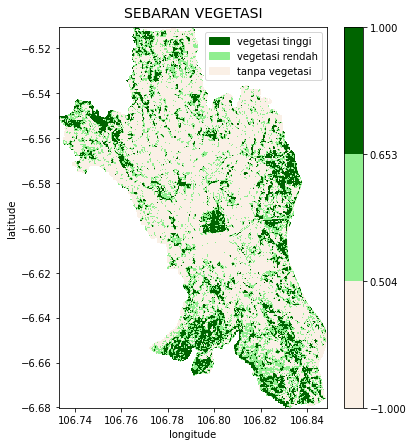

In [6]:
ndvi = (preprocessed_band[5]-preprocessed_band[4]) / (preprocessed_band[5]+preprocessed_band[4])
class_ndvi = [-1., low_veg_ndvi.min(), high_veg_ndvi.min(), 1.]
colors = ["linen", "lightgreen", "darkgreen"]
cmap = ListedColormap(colors)
norm = BoundaryNorm(class_ndvi, len(colors))

fig, ax = plt.subplots(figsize=(6, 7))

ndvi.plot.imshow(ax=ax, cmap=cmap, norm=norm)
ax.set_title("SEBARAN VEGETASI", fontsize=14, pad=10)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

high_patch = mpatches.Patch(color="darkgreen", label="vegetasi tinggi")
low_patch = mpatches.Patch(color="lightgreen", label="vegetasi rendah")
no_patch = mpatches.Patch(color="linen", label="tanpa vegetasi")

plt.legend(handles=[high_patch, low_patch, no_patch])
plt.show()

## PERHITUNGAN EVAPOTRANSPIRASI POTENSIAL

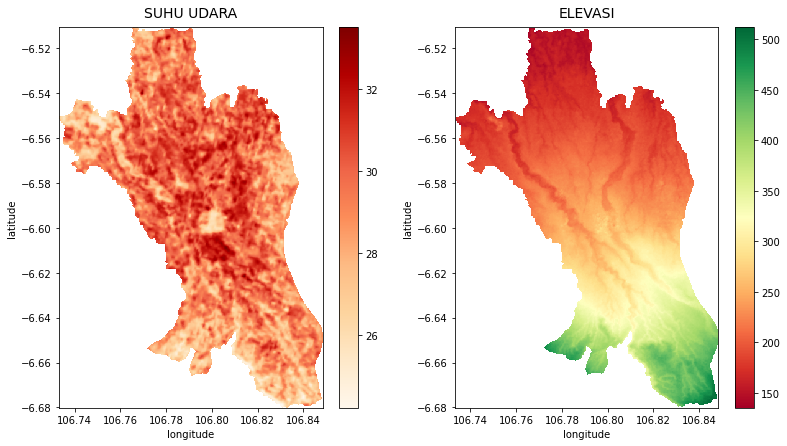

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(13, 7))

temperature.plot.imshow(ax=axs[0], cmap="OrRd")
axs[0].set_title("SUHU UDARA", fontsize=14, pad=10)
axs[0].set_xlabel("longitude")
axs[0].set_ylabel("latitude")

elevation.plot.imshow(ax=axs[1], cmap="RdYlGn")
axs[1].set_title("ELEVASI", fontsize = 14, pad = 10)
axs[1].set_xlabel("longitude")
axs[1].set_ylabel("latitude")

plt.show()

In [8]:
climate = pd.read_csv(f"output/climate/landsat-climate.csv")
climate = climate.loc[climate["time"] == time]
climate

,time,temperature_avg,temperature_min,temperature_max,relative_humidity,sunshine_duration,wind_velocity,precipitation,julian,clear_area_km,clear_area_pc
1,2019-07-25,25.85,21.2,33.2,70.158,6.7,0.565,0.0,206.0,116.8209,100.0


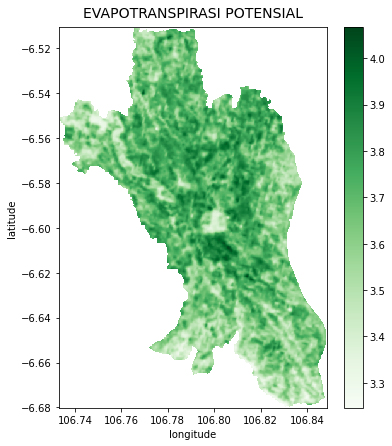

In [9]:
latitude = 3.14 / 180 * np.array([[i for j in range(temperature.shape[1])] for i in np.array(temperature["y"])])
humidity = climate["relative_humidity"].values[0]
sunshine_duration = climate["sunshine_duration"].values[0]
wind_velocity = climate["wind_velocity"].values[0]
julian = climate["julian"].values[0]

atmospheric_pressure = 101.3 * ((293 - 0.0065 * elevation) / 293) ** 5.26
solar_declination = 0.409 * np.sin(2 * 3.14 / 365 * julian - 1.39)
sunset_angel = np.arccos(-np.tan(latitude) * np.tan(solar_declination))
earth_sun_distance = 1 + 0.033 * np.cos(2 * 3.14 / 365 * julian)
daylight = 24 / 3.14 * sunset_angel

saturation_vapour_pressure = 0.6108 * np.exp(17.27 * temperature / (temperature+237.3))
actual_vapour_pressure = saturation_vapour_pressure * humidity / 100
saturation_vapour_pressure_curve = 4098 * saturation_vapour_pressure / (temperature+237.3) ** 2
latent_heat_vaporization = 2.501 - (2.361 * 10 ** -3) * temperature
psychrometric_constant = 0.00163 * atmospheric_pressure / latent_heat_vaporization
atmospheric_emissivity = 0.34 - 0.14 * np.sqrt(actual_vapour_pressure)
cloud_cover = 0.9 * sunshine_duration / daylight + 0.1

extraterrestrial_radiation = 24 * 60 / 3.14 * 0.0820 * earth_sun_distance * (sunset_angel * np.sin(latitude) * np.sin(solar_declination) + np.cos(latitude) * np.cos(solar_declination)  * np.sin(sunset_angel))
solar_radiation = (0.25 + 0.5 * sunshine_duration / daylight) * extraterrestrial_radiation
net_shortwave_radiation = (1-0.23) * solar_radiation
net_longwave_radiation = cloud_cover * atmospheric_emissivity * 0.000000004903 * (temperature+273) ** 4
net_radiation = net_shortwave_radiation - net_longwave_radiation

etpotential = (0.408 * saturation_vapour_pressure_curve * net_radiation + psychrometric_constant * (900 / (temperature+273)) * wind_velocity * (saturation_vapour_pressure-actual_vapour_pressure)) / (saturation_vapour_pressure_curve + (psychrometric_constant * (1 + 0.34 * wind_velocity)))

etpotential_min = etpotential.min().values.round(3)
etpotential_max = etpotential.max().values.round(3)

fig, ax = plt.subplots(figsize=(6, 7))

etpotential.plot.imshow(ax=ax, cmap="Greens")
ax.set_title("EVAPOTRANSPIRASI POTENSIAL", fontsize=14, pad=10)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

plt.show()

## PERHITUNGAN INDEKS EVAPOTRANSPIRASI

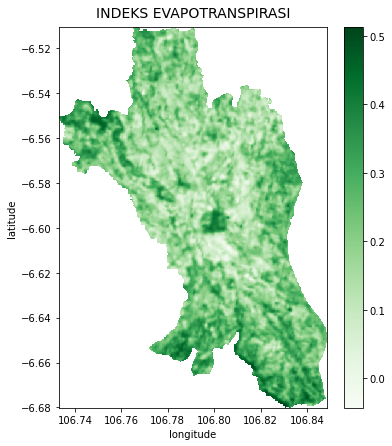

nilai minimum indeks evapotranspirasi -0.043
nilai maksimum indeks evapotranspirasi 0.512
nilai etindex yang underestimated 0.11%
nilai etindex yang overestimated 0.0%


In [10]:
latitude_dec = np.array([[i for j in range(temperature.shape[1])] for i in np.array(temperature["y"])])

latitude_factor = -0.0021 * (latitude_dec**2) + 0.3449 * abs(latitude_dec) - 2.9864
solar_radiation_watt = solar_radiation * 1000000 / (sunshine_duration*3600)
wet_temperature = 0.06 * solar_radiation_watt - 30.34 - np.sin(2 * 3.14 * (julian+220) / 365) * 0
dry_temperature = wet_temperature + (-0.0023 * wind_velocity + 0.0301) * solar_radiation_watt

etindex = 1.23 * (dry_temperature-temperature) / (dry_temperature-wet_temperature)
etindex_min = etindex.min().values.round(3)
etindex_max = etindex.max().values.round(3)

area = etindex.count().values
underes = etindex.where(etindex < 0).count().values
overes = etindex.where(etindex > 1.23).count().values
underes_pc = round(underes / area * 100, 2)
overes_pc = round(overes / area * 100, 2)

fig, ax = plt.subplots(figsize=(6, 7))

etindex.plot.imshow(ax=ax, cmap="Greens", vmin=etindex.min(), vmax=etindex.max())
ax.set_title("INDEKS EVAPOTRANSPIRASI", fontsize=14, pad=10)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

plt.show()

print(f"nilai minimum indeks evapotranspirasi {etindex_min}")
print(f"nilai maksimum indeks evapotranspirasi {etindex_max}")
print(f"nilai etindex yang underestimated {underes_pc}%")
print(f"nilai etindex yang overestimated {overes_pc}%")

## ADJUSTMENT INDEKS EVAPOTRANSPIRASI

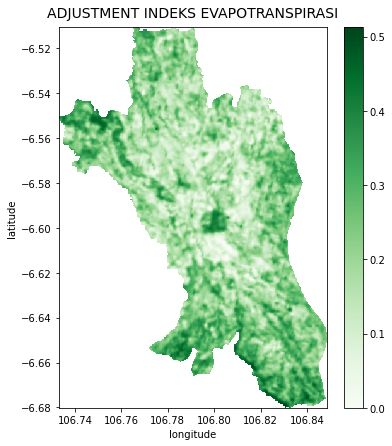

In [11]:
etindex_under_validated = xr.where(etindex > 1.23, 1.23, etindex)
etindex_over_validated = xr.where(etindex_under_validated < 0, 0, etindex_under_validated)

fig, ax = plt.subplots(figsize=(6, 7))

etindex_over_validated.plot.imshow(ax=ax, cmap="Greens",
                                   vmin=etindex_over_validated.min(),
                                   vmax=etindex_over_validated.max())
ax.set_title("ADJUSTMENT INDEKS EVAPOTRANSPIRASI", fontsize=14, pad=10)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

plt.show()

## PERHITUNGAN EVAPOTRANSPIRASI AKTUAL

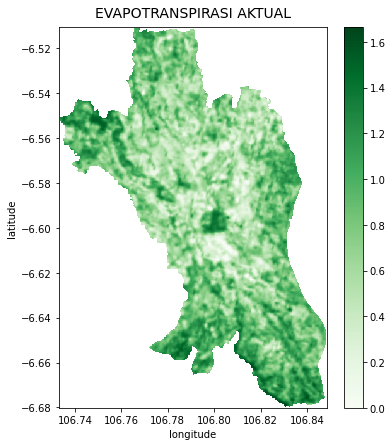

In [12]:
etactual = etpotential * etindex_over_validated

fig, ax = plt.subplots(figsize=(6, 7))

etactual.plot.imshow(ax=ax, cmap="Greens")
ax.set_title("EVAPOTRANSPIRASI AKTUAL", fontsize=14, pad=10)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

plt.show()

## RATA-RATA EVAPOTRANSPIRASI

In [13]:
ndvi_classed = xr.apply_ufunc(np.digitize, ndvi, class_ndvi)
ndvi_nan = ndvi_classed.where(ndvi_classed != 4)

etpotential_no_veg = etpotential.where(ndvi_nan.isin(1)).mean().values.round(4)
etpotential_low_veg = etpotential.where(ndvi_nan.isin(2)).mean().values.round(4)
etpotential_high_veg = etpotential.where(ndvi_nan.isin(3)).mean().values.round(4)

etindex_no_veg = etindex.where(ndvi_nan.isin(1)).mean().values.round(4)
etindex_low_veg = etindex.where(ndvi_nan.isin(2)).mean().values.round(4)
etindex_high_veg = etindex.where(ndvi_nan.isin(3)).mean().values.round(4)

etactual_no_veg = etactual.where(ndvi_nan.isin(1)).mean().values.round(4)
etactual_low_veg = etactual.where(ndvi_nan.isin(2)).mean().values.round(4)
etactual_high_veg = etactual.where(ndvi_nan.isin(3)).mean().values.round(4)

et_mean = {
    "vegetasi": ["tanpa vegetasi", "vegetasi rendah", "vegetasi tinggi"],
    "etpotential": [etpotential_no_veg, etpotential_low_veg, etpotential_high_veg],
    "etindex": [etindex_no_veg, etindex_low_veg, etindex_high_veg],
    "etactual": [etactual_no_veg, etactual_low_veg, etactual_high_veg]
}

et_mean_level = pd.DataFrame(et_mean, columns = ["vegetasi", "etpotential", "etindex", "etactual"])
et_mean_level

,vegetasi,etpotential,etindex,etactual
0,tanpa vegetasi,3.7381,0.1666,0.6149
1,vegetasi rendah,3.6093,0.2533,0.9067
2,vegetasi tinggi,3.5136,0.3194,1.1146


## MATRIX KORELASI

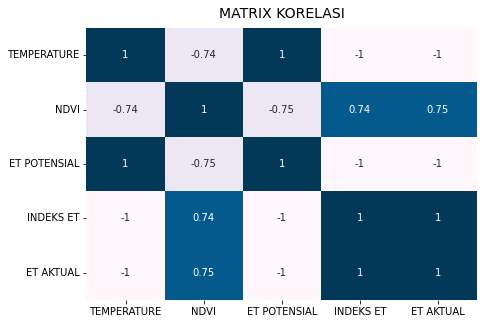

In [14]:
temperature_flatten = temperature.values.flatten()
ndvi_flatten = ndvi.values.flatten()
etindex_flatten = etindex_over_validated.values.flatten()
etpotential_flatten = etpotential.values.flatten()
etactual_flatten = etactual.values.flatten()
param = {
    "TEMPERATURE": temperature_flatten,
    "NDVI": ndvi_flatten,
    "ET POTENSIAL": etpotential_flatten,
    "INDEKS ET": etindex_flatten,
    "ET AKTUAL": etactual_flatten
}

param_et = pd.DataFrame(param, columns = ["TEMPERATURE", "NDVI", "ET POTENSIAL", "INDEKS ET", "ET AKTUAL"])
param_et_nan = param_et.dropna()
param_et_corr = param_et_nan.corr()

fig, ax = plt.subplots(figsize=(7, 5))

sns.heatmap(param_et_corr,
            cmap="PuBu", 
            annot=True,
            cbar=False,
            xticklabels=param_et_corr.columns,
            yticklabels=param_et_corr.columns)
ax.set_title("MATRIX KORELASI", fontsize=14, pad=10)

plt.show()